minimize $\int^{T}_{t=0} (x_0^2+ x_1^2+u^2) dt$

subject to:
\begin{equation}
\left\{
        \begin{array}{lr}
            \dot{x_0}= (1-x_1^2)x_0-x_1+u, &  \\
            \dot{x_1}= x_0, & 0 \leq t \leq T\\
            -1.0 \leq u \leq 1.0, & x_1 \ge -0.25 \\
            x_0(0)=0; \quad x_1(0)=1
        \end{array}
\right.
\end{equation}

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

1. use Gauss Legendre collocation to insert discrete points. assume $d=3$ so $t_{k,d}= [t_{k, 1}, t_{k,2}, t_{k,3}]$ are inserted into $[t_k, t_{k+1}]$
2. the trajectory of $[t_k, t_{k+1}]$ is approximated by a Lagrange polynomials

    $P_k= \sum_{k=0}^{N-1} p_{k,i} l_{k,i}(t)$, $\quad$ $l_{k,i}= \prod_{j=0, j\neq i}^{d} \frac{t-t_{k,j}}{t_{k,i}- t_{k,j}}$

3. $P_k$ should satisfy initial condition: $P_k(t_k)= x_k$
4. The collocation points satisfy state space equations, this converts into a ODE matrix $C$
5. $P_k$ meets the end states


In [2]:
d=3                     # degree of interpolating polynomial
collocate_points= np.append(0, ca.collocation_points(d,'legendre'))        #get collocation points

B= np.zeros(d+1)            # Coefficients of the quadrature function
C= np.zeros((d+1, d+1))     # Coefficients of the collocation equation
D= np.zeros(d+1)            # Coefficients of the continuity equation

# Construct Lagrange polynomials to get the polynomial basis at the collocation point
for i in range (d+1):
    p= np.poly1d([1])
    for j in range (d+1):
        if j != i:
            p *= np.poly1d([1, -collocate_points[j]])/ (collocate_points[i]- collocate_points[j])

    #Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    D[i]= p(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    dp= np.polyder(p)
    for j in range (d+1):
        C[i,j]= dp(collocate_points[j])

    # Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    intp= np.polyint(p)
    B[i]= intp(1.0)

$D= [L_1(1.0), L_2(1.0), L_3(1.0), L_4(1.0)]$

$C= \left[
\begin{matrix}
    \dot{L_0}(\tau_0) & \dot{L_0}(\tau_1) & \dot{L_0}(\tau_2) & \dot{L_0}(\tau_3)\\
    \dot{L_1}(\tau_0) & \dot{L_1}(\tau_1) & \dot{L_1}(\tau_2) & \dot{L_1}(\tau_3)\\
    \dot{L_2}(\tau_0) & \dot{L_2}(\tau_1) & \dot{L_2}(\tau_2) & \dot{L_2}(\tau_3)\\
    \dot{L_3}(\tau_0) & \dot{L_3}(\tau_1) & \dot{L_3}(\tau_2) & \dot{L_3}(\tau_3)\\
\end{matrix}
\right]$

$B= [\int L_1(1.0), \int L_2(1.0), \int L_3(1.0), \int L_4(1.0)]$

In [3]:
T= 10
N= 20                   # number of control intervals
h= T/N

# Declare model variables
x1 = ca.SX.sym('x1')
x2 = ca.SX.sym('x2')
x = ca.vertcat(x1, x2)
u = ca.SX.sym('u')

# Model states, state equations, objective function
dx= ca.vertcat((1-x2**2)*x1 - x2 + u, x1)
L= x1**2 + x2**2 + u**2
f= ca.Function('f', [x, u], [dx, L], ['x', 'u'], ['dx', 'L'])       # Continuous time dynamics

In [4]:
# Start with an empty NLP
w=[]
w0= []
lbw= []
ubw= []
lbg= []
ubg= []
J= 0
g=[]
x_plot = []
u_plot = []

Xk= ca.MX.sym('X0', x.size()[0])
w.append(Xk)
lbw.append([0, 1])
ubw.append([0, 1])
w0.append([0, 1])
x_plot.append(Xk)

In [5]:
# Start to loop each segment
for k in range (N):
    Uk= ca.MX.sym('U_'+ str(k))
    w.append(Uk)
    lbw.append([-1])
    ubw.append([1])
    w0.append([0])
    u_plot.append(Uk)

    Xc= []
    for j in range (d):
        Xkj= ca.MX.sym('X_'+ str(k)+ '_'+ str(j), x.size()[0])
        Xc.append(Xkj)
        w.append(Xkj)
        lbw.append([-0.25, -np.inf])
        ubw.append([np.inf, np.inf])
        w0.append([0, 0])

    Xk_end= D[0]*Xk

    for j in range (1, d+1):
        xp= C[0, j]*Xk
        for r in range(d):
            xp += C[r+1, j]* Xc[r]

        fj, qj= f(Xc[j-1], Uk)
        g.append(h*fj- xp)
        lbg.append([0, 0])
        ubg.append([0, 0])

        Xk_end= Xk_end+ D[j]* Xc[j-1]
        J= J+ B[j]* qj* h

    Xk= ca.MX.sym('X_'+ str(k+1), 2)
    w.append(Xk)
    lbw.append([-0.25, -np.inf])
    ubw.append([np.inf,  np.inf])
    w0.append([0, 0])
    x_plot.append(Xk)

    g.append(Xk_end-Xk)
    lbg.append([0, 0])
    ubg.append([0, 0])

In [6]:
w= ca.vertcat(*w)
g = ca.vertcat(*g)
x_plot = ca.horzcat(*x_plot)
u_plot = ca.horzcat(*u_plot)
w0 = np.concatenate(w0)
lbw = np.concatenate(lbw)
ubw = np.concatenate(ubw)
lbg = np.concatenate(lbg)
ubg = np.concatenate(ubg)

prob= {'f': J, 'x': w, 'g': g}
solver= ca.nlpsol('solver', 'ipopt', prob)

trajectories= ca.Function('trajectories', [w], [x_plot, u_plot], ['w'], ['x', 'u'])
sol= solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
x_opt, u_opt = trajectories(sol['x'])
x_opt = x_opt.full() # to numpy array
u_opt = u_opt.full() # to numpy array


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      852
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      180
                     variables with only lower bounds:       80
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equa

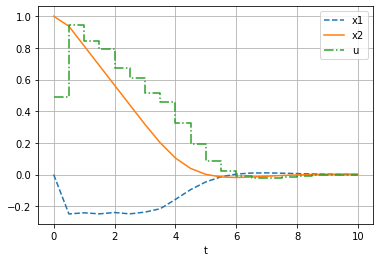

In [7]:
# Plot the result
tgrid = np.linspace(0, T, N+1)
plt.figure(1)
plt.clf()
plt.plot(tgrid, x_opt[0], '--')
plt.plot(tgrid, x_opt[1], '-')
plt.step(tgrid, np.append(np.nan, u_opt[0]), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()